<a href='#2' > Подсчет процента пропусков

<a href='#3' > 1. Признак City
    
<a href='#4' > 2. Признак Price Range
    
<a href='#5' > 3. Признак Cuisine Style
    
<a href='#5.1' > 3.1 Варинат 1

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MultiLabelBinarizer # Для кодирования Cuisine Style в dummy-переменные

## Пользовательсике фукнции

In [2]:
def clean_name(str_val):
    """
    Преобразует строку с названиями кухонь в список [list] названий кухонь.
    На входе:
        - строковая переменная, содержащая названия кухонь.
    На выходе:
        - список [list] названий кухонь.
    """
    if pd.isna(str_val): return ["Unknown"]
    str_val = str_val.strip('[]') # Отбрасываем скобки.
    str_val = str_val.replace("\'",'') # Убираем кавычки '.
    str_val = str_val.split(", ") # Разбиваем строку по названиям кухонь.
    return str_val

In [3]:
mt = pd.read_csv('main_task.csv')
mt.head(10)

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963
5,id_1418,Oporto,NaN,1419.0,3.0,NaN,2.0,"[['There are better 3 star hotel bars', 'Amazi...",/Restaurant_Review-g189180-d12503536-Reviews-D...,d12503536
6,id_1720,Milan,"['Italian', 'Pizza']",1722.0,4.0,$,50.0,"[['Excellent simple local eatery.', 'Excellent...",/Restaurant_Review-g187849-d5808504-Reviews-Pi...,d5808504
7,id_825,Bratislava,['Italian'],826.0,3.0,NaN,9.0,"[['Wasting of money', 'excellent cuisine'], ['...",/Restaurant_Review-g274924-d3199765-Reviews-Ri...,d3199765
8,id_2690,Vienna,NaN,2692.0,4.0,NaN,NaN,"[[], []]",/Restaurant_Review-g190454-d12845029-Reviews-G...,d12845029
9,id_4209,Rome,"['Italian', 'Pizza', 'Fast Food']",4210.0,4.0,$,55.0,"[['Clean efficient staff', 'Nice little pizza ...",/Restaurant_Review-g187791-d8020681-Reviews-Qu...,d8020681


In [4]:
mt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


## Использование модели №0
Без обработки данных, только количесвтенные признаки




In [11]:
df = mt.loc[:,('Ranking', 'Rating', 'Number of Reviews')]

In [12]:
df.fillna(0, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ranking            40000 non-null  float64
 1   Rating             40000 non-null  float64
 2   Number of Reviews  40000 non-null  float64
dtypes: float64(3)
memory usage: 937.6 KB


In [14]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['Rating'], axis = 1)
y = df['Rating']

In [15]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [17]:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [18]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [19]:
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.4296526077380952


In [20]:
#Проверим датасет на наличие дубликатов:
if len(mt)>len(mt.drop_duplicates()):
    print('Дубликаты есть')
    display(mt[mt.duplicated()])
else:
    print('Дубликатов нет')

Дубликатов нет


In [21]:
# FIXME
# Посмотрим как распеделены пропуски по датасету:
#plt.figure(figsize=(10, 7))# размер тепловой карты
#sns.heatmap(mt.iloc[1:1000].isnull(), cmap="YlGnBu", annot=True);

<a id='2'> </a>
#### Процент прпусков

In [22]:
# Считаем процент пропусков
per_none = pd.DataFrame(1-mt.count()/mt.shape[0]).reset_index().rename({0: 'percent'}, axis=1)
per_none = per_none.sort_values('percent', ascending=False).query('percent>0')

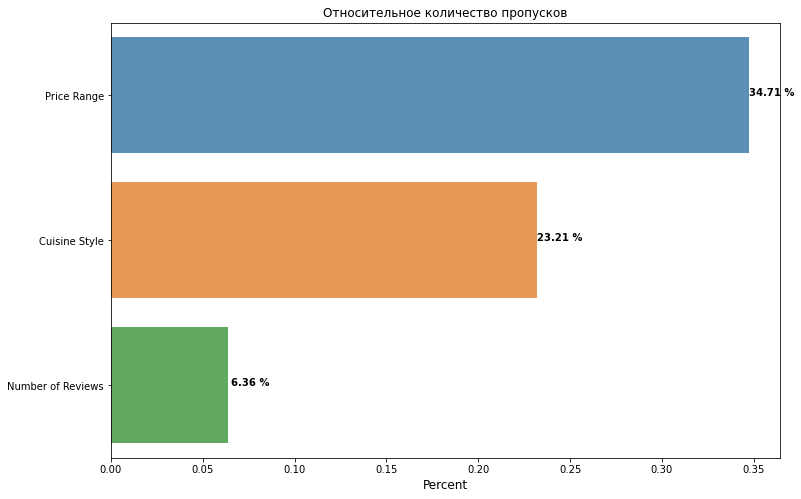

In [23]:
fig, ax = plt.subplots(figsize = (12, 8))
bar_plot = sns.barplot(x='percent', y='index', data=per_none, alpha=0.8, ci=None)
for ytick in bar_plot.get_yticks():
    if per_none.iloc[ytick][1]>0:
        bar_plot.text(per_none.iloc[ytick][1]+0.0125, ytick, str(round(per_none.iloc[ytick][1]*100,2))+' %', 
                    horizontalalignment='center',size=10, color='black', weight='semibold')
plt.title('Относительное количество пропусков')
plt.ylabel('')
plt.xlabel('Percent', fontsize=12)
plt.show()

Пропуски есть в 3 из 10 колонках. Больше всего пропуско в колонке Price Range.

Максимальное коичество пропусков в строке:

In [24]:
# подстчитаем количесвто пропусков в строке и сколько строк имеет такое количество пропусков
count_nullrows = mt.apply(lambda x: sum(x.isnull()), axis=1).value_counts()
# процент незаполненых знчений в строке
percent_nans=round(pd.Series(count_nullrows.index/mt.shape[1]*100)).sort_values(ascending=False).astype(str)+' %'
misses = max(mt.apply(lambda x: sum(x.isnull()), axis=1))/mt.shape[1]
print('Максимум незаполненных строк в датафрейме:', round(misses*100, 2), "%")
null_str = pd.DataFrame({'Количество строк с пропусками N': count_nullrows, 
              'Количество пропусков в строке (N)': count_nullrows.index,
              'Процент незаполненных значений в строке': percent_nans})
null_str = null_str.sort_values('Количество пропусков в строке (N)', ascending=False).reset_index().drop('index',axis=1)
display(null_str)
print ('Ничего удалять не будем')

Максимум незаполненных строк в датафрейме: 30.0 %


,Количество строк с пропусками N,Количество пропусков в строке (N),Процент незаполненных значений в строке
0,1357,3,30.0 %
1,4257,2,20.0 %
2,8692,1,10.0 %
3,25694,0,0.0 %


Ничего удалять не будем


## Целевая переменная - Rating

In [25]:
t = 'Rating'

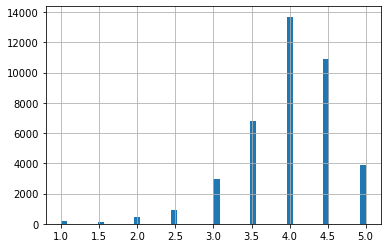

In [26]:
mt[t].hist(bins=50)

In [388]:
mt[t].value_counts()

4.0    13692
4.5    10929
3.5     6824
5.0     3879
3.0     2955
2.5      915
2.0      466
1.0      201
1.5      139
Name: Rating, dtype: int64

<a id='3'> </a>
### 1. Признак City 

In [27]:
mt['City'].unique()

array(['Paris', 'Stockholm', 'London', 'Berlin', 'Munich', 'Oporto',
       'Milan', 'Bratislava', 'Vienna', 'Rome', 'Barcelona', 'Madrid',
       'Dublin', 'Brussels', 'Zurich', 'Warsaw', 'Budapest', 'Copenhagen',
       'Amsterdam', 'Lyon', 'Hamburg', 'Lisbon', 'Prague', 'Oslo',
       'Helsinki', 'Edinburgh', 'Geneva', 'Ljubljana', 'Athens',
       'Luxembourg', 'Krakow'], dtype=object)

In [28]:
mt['City'].nunique()

31

In [29]:
mt['City'].value_counts()

London        5757
Paris         4897
Madrid        3108
Barcelona     2734
Berlin        2155
Milan         2133
Rome          2078
Prague        1443
Lisbon        1300
Vienna        1166
Amsterdam     1086
Brussels      1060
Hamburg        949
Munich         893
Lyon           892
Stockholm      820
Budapest       816
Warsaw         727
Dublin         673
Copenhagen     659
Athens         628
Edinburgh      596
Zurich         538
Oporto         513
Geneva         481
Krakow         443
Oslo           385
Helsinki       376
Bratislava     301
Luxembourg     210
Ljubljana      183
Name: City, dtype: int64

##### Создаем новый признак на основе признака City - Численость населения.

In [30]:
# Численость населения вгородах
pop = {'London': 8_908_081, 'Paris':2_148_327, 'Madrid': 3_266_126, 'Barcelona': 1_664_182, 'Berlin': 3_644_826,
       'Milan': 1_378_689, 'Rome': 2_870_500, 'Prague': 1_301_132, 'Lisbon': 505_526, 'Vienna': 1_897_491, 
       'Amsterdam': 872_757, 'Brussels': 179_277, 'Hamburg': 1_841_179, 'Munich': 1_471_508, 'Lyon': 506_615,
       'Stockholm': 961_609, 'Budapest': 1_752_286, 'Warsaw': 1_790_658, 'Dublin': 1_173_179, 'Copenhagen': 615_993,
       'Athens': 664_046, 'Edinburgh': 488_100, 'Zurich': 428_737, 'Oporto': 237_591, 'Geneva': 200_548, 'Krakow': 779_115,
       'Oslo': 673_469, 'Helsinki': 655_281, 'Bratislava': 437_725, 'Luxembourg': 626_108, 'Ljubljana': 284_355
      }

In [31]:
pop['Munich']

1471508

In [32]:
mt['pop'] = mt.loc[:, ('City')].apply(lambda x: pop[x])

In [33]:
mt.loc[:15, ('City', 'pop')]

,City,pop
0,Paris,2148327
1,Stockholm,961609
2,London,8908081
3,Berlin,3644826
4,Munich,1471508
5,Oporto,237591
6,Milan,1378689
7,Bratislava,437725
8,Vienna,1897491
9,Rome,2870500


##### Создаем новый бинарсный признак на основе признака City - Стлица. (is_capital)

In [34]:
capital = {'London': 1, 'Paris':1, 'Madrid':1, 'Barcelona': 0, 'Berlin':1,
       'Milan':0, 'Rome':1, 'Prague':1, 'Lisbon':1, 'Vienna':1, 
       'Amsterdam':1, 'Brussels':1, 'Hamburg':0, 'Munich':0, 'Lyon':0,
       'Stockholm':1, 'Budapest':1, 'Warsaw':1, 'Dublin':1, 'Copenhagen':1,
       'Athens':1, 'Edinburgh':1, 'Zurich':1, 'Oporto':0, 'Geneva':0, 'Krakow':0,
       'Oslo':1, 'Helsinki':1, 'Bratislava':1, 'Luxembourg':1, 'Ljubljana':1
      }

In [35]:
mt['is_capital'] = mt.loc[:, ('City')].apply(lambda x: capital[x])

In [36]:
mt.loc[4:10, ('City', 'pop', 'is_capital')]

,City,pop,is_capital
4,Munich,1471508,0
5,Oporto,237591,0
6,Milan,1378689,0
7,Bratislava,437725,1
8,Vienna,1897491,1
9,Rome,2870500,1
10,Barcelona,1664182,0


In [37]:
mt.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,pop,is_capital
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,2148327,1
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,961609,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,8908081,1
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,3644826,1
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1471508,0


In [38]:
dft = mt.loc[:, ('City','pop')]
dft.describe()

,pop
count,4.000000e+04
mean,2.742560e+06
std,2.694562e+06
min,1.792770e+05
25%,9.616090e+05
50%,1.841179e+06
75%,3.266126e+06
max,8.908081e+06


In [450]:
dft['pop']

0        2148327
1         961609
2        8908081
3        3644826
4        1471508
          ...   
39995    1378689
39996    2148327
39997     961609
39998    1790658
39999    1378689
Name: pop, Length: 40000, dtype: int64

In [453]:
#pd.qcut(dft['pop'], q=3)

Создаем порядковый категориальный признак численность населения

In [454]:
dft['pop_cat'] = pd.qcut(dft['pop'], q=[0, 1/3, 2/3, 1],  labels=[1, 2, 3])
dft

,City,pop,pop_cat
0,Paris,2148327,2
1,Stockholm,961609,1
2,London,8908081,3
3,Berlin,3644826,3
4,Munich,1471508,2
...,...,...,...
39995,Milan,1378689,1
39996,Paris,2148327,2
39997,Stockholm,961609,1
39998,Warsaw,1790658,2


In [456]:
dft.describe(include='category')

,pop_cat
count,40000
unique,3
top,1
freq,14720


<a id='4'> </a>
### 2. Признак Price Range

In [400]:
mt['Price Range'].unique()

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [401]:
mt['Price Range'].nunique()

3

In [402]:
mt['Price Range'].value_counts()

$$ - $$$    18412
$            6279
$$$$         1423
Name: Price Range, dtype: int64

In [403]:
# Количество пропущенных
mt['Price Range'].isna().sum()

13886

In [404]:
# Заполним пропуски самым частым значением - Средним ценовым сигментом.
mt = mt.fillna({'Price Range': '$$ - $$$'})

In [405]:
mt['Price Range'].unique()

array(['$$ - $$$', '$$$$', '$'], dtype=object)

In [406]:
mt['Price Range'].value_counts()

$$ - $$$    32298
$            6279
$$$$         1423
Name: Price Range, dtype: int64

Признак Price Range - порядковый категориальный признак. Закодируем его методом replace() как:

- \$ - низкий ценовой сегмент стоимость = 1


- \$\$ - средний ценовой сегмент = 2 


- \$$\$$ - высокий ценовой сегмент = 3

In [407]:
cleanup_price ={'Price Range': {'$':1, '$$ - $$$':2, '$$$$':3 }}

In [408]:
mt = mt.replace(cleanup_price)

In [409]:
mt.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,pop,is_capital
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,2148327,1
1,id_1535,Stockholm,NaN,1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,961609,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,8908081,1
3,id_3456,Berlin,NaN,3458.0,5.0,2,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,3644826,1
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,2,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1471508,0


<a id='5'> </a>
### 3. Признак Cuisine Style

In [410]:
dft = mt['Cuisine Style']
dft = dft.apply(clean_name)
dfte = dft.explode() # Для подсчета всех кухонь в датасете
dfte.value_counts()

Vegetarian Friendly    11189
European               10060
Unknown                 9283
Mediterranean           6277
Italian                 5964
                       ...  
Latvian                    1
Xinjiang                   1
Burmese                    1
Salvadoran                 1
Yunnan                     1
Name: Cuisine Style, Length: 126, dtype: int64

Какое среднее количество кухонь предлагается в одном ресторане? 

In [411]:
round(dft.apply(lambda x: len(x)).mean(),1)

2.6

<a id='5.1'> </a>
### 3.1 Вариант 1. Пустые значения заменяем на "European". Создаем из этого признака dummy- переменную

In [412]:
df_for_mod_1 = mt.loc[:,:] # Создаем датасет для моделирования № 1

In [413]:
df_for_mod_1.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,pop,is_capital
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,2148327,1
1,id_1535,Stockholm,NaN,1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032,961609,1
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781,8908081,1
3,id_3456,Berlin,NaN,3458.0,5.0,2,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776,3644826,1
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,2,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963,1471508,0


In [414]:
# Сделаем значения признака Cuisine Style в виде списка
df_for_mod_1['Cuisine Style'] = df_for_mod_1['Cuisine Style'].apply(clean_name)

In [415]:
# Заменим пустые значения на список из 2х самых популярных кухонь "European" и "Vegetarian Friendly"
df_for_mod_1['Cuisine Style'] = df_for_mod_1['Cuisine Style'].apply(lambda x: ['European', 'Vegetarian Friendly'] 
                                                                    if x == ['Unknown'] else x )

In [416]:
#dfte = dft.explode()
#dfte.unique()
# FIXME

In [417]:
df_for_mod_1 = df_for_mod_1.drop(['Restaurant_id', 'URL_TA', 'ID_TA'], axis=1)

In [418]:
df_for_mod_1


,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,pop,is_capital
0,Paris,"[European, French, International]",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",2148327,1
1,Stockholm,"[European, Vegetarian Friendly]",1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",961609,1
2,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",8908081,1
3,Berlin,"[European, Vegetarian Friendly]",3458.0,5.0,2,3.0,"[[], []]",3644826,1
4,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,2,84.0,"[['Best place to try a Bavarian food', 'Nice b...",1471508,0
...,...,...,...,...,...,...,...,...,...
39995,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,2,79.0,"[['The real Italian experience!', 'Wonderful f...",1378689,0
39996,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",2148327,1
39997,Stockholm,"[Japanese, Sushi]",1652.0,4.5,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",961609,1
39998,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",1790658,1


##### Создание dummy-переменной

In [364]:
mlb = MultiLabelBinarizer()

In [428]:
mlb_df = pd.DataFrame(mlb.fit_transform(df_for_mod_1['Cuisine Style']), columns=mlb.classes_)

In [429]:
mlb_df

,Afghani,African,Albanian,American,Arabic,Argentinean,Armenian,Asian,Australian,Austrian,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,1,1,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,0,0,0,0,0,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
39996,0,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
39997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [430]:
df_for_mod_1 = pd.concat([df_for_mod_1, mlb_df], axis=1)
df_for_mod_1

,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,pop,is_capital,Afghani,...,Ukrainian,Uzbek,Vegan Options,Vegetarian Friendly,Venezuelan,Vietnamese,Welsh,Wine Bar,Xinjiang,Yunnan
0,Paris,"[European, French, International]",5570.0,3.5,2,194.0,"[['Good food at your doorstep', 'A good hotel ...",2148327,1,0,...,0,0,0,0,0,0,0,0,0,0
1,Stockholm,"[European, Vegetarian Friendly]",1537.0,4.0,2,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",961609,1,0,...,0,0,0,1,0,0,0,0,0,0
2,London,"[Japanese, Sushi, Asian, Grill, Vegetarian Fri...",353.0,4.5,3,688.0,"[['Catch up with friends', 'Not exceptional'],...",8908081,1,0,...,0,0,1,1,0,0,0,0,0,0
3,Berlin,"[European, Vegetarian Friendly]",3458.0,5.0,2,3.0,"[[], []]",3644826,1,0,...,0,0,0,1,0,0,0,0,0,0
4,Munich,"[German, Central European, Vegetarian Friendly]",621.0,4.0,2,84.0,"[['Best place to try a Bavarian food', 'Nice b...",1471508,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,Milan,"[Italian, Vegetarian Friendly, Vegan Options, ...",500.0,4.5,2,79.0,"[['The real Italian experience!', 'Wonderful f...",1378689,0,0,...,0,0,1,1,0,0,0,0,0,0
39996,Paris,"[French, American, Bar, European, Vegetarian F...",6341.0,3.5,2,542.0,"[['Parisian atmosphere', 'Bit pricey but inter...",2148327,1,0,...,0,0,0,1,0,0,0,0,0,0
39997,Stockholm,"[Japanese, Sushi]",1652.0,4.5,2,4.0,"[['Good by swedish standards', 'A hidden jewel...",961609,1,0,...,0,0,0,0,0,0,0,0,0,0
39998,Warsaw,"[Polish, European, Eastern European, Central E...",641.0,4.0,2,70.0,"[['Underground restaurant', 'Oldest Restaurant...",1790658,1,0,...,0,0,0,1,0,0,0,0,0,0


In [424]:
corrt = mt.loc[:, :]
corrt = corrt.drop(['Restaurant_id', 'URL_TA', 'ID_TA', 'City', 'Cuisine Style', 'Reviews'], axis=1)

In [425]:
corrt

,Ranking,Rating,Price Range,Number of Reviews,pop,is_capital
0,5570.0,3.5,2,194.0,2148327,1
1,1537.0,4.0,2,10.0,961609,1
2,353.0,4.5,3,688.0,8908081,1
3,3458.0,5.0,2,3.0,3644826,1
4,621.0,4.0,2,84.0,1471508,0
...,...,...,...,...,...,...
39995,500.0,4.5,2,79.0,1378689,0
39996,6341.0,3.5,2,542.0,2148327,1
39997,1652.0,4.5,2,4.0,961609,1
39998,641.0,4.0,2,70.0,1790658,1


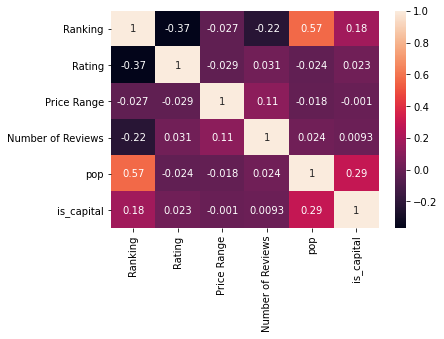

In [427]:
sns.heatmap(corrt.corr(), annot=True);
